# MNIST Data Preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
print('Train Data:', x_train.shape, ',', 'Train Labels:', y_train.shape)
print('Test Data:', x_test.shape, ',', 'Test Labels:', y_test.shape)

Train Data: (60000, 28, 28) , Train Labels: (60000,)
Test Data: (10000, 28, 28) , Test Labels: (10000,)


## Preprocessing Dataset

- Divide Training set into **training and validation set**.
- Flatten Image Data: (28,28) -> (784,)
- One-hot encode labels: 3 -> (0,0,0,1,0,0,0,0,0,0)
- Normalize Images

In [5]:
x_train, x_valid = x_train[:50000], x_train[50000:]
y_train, y_valid = y_train[:50000], y_train[50000:]

In [6]:
x_train = x_train.reshape(50000,28*28)/256
x_valid = x_valid.reshape(-1, 28*28)/256
x_test  = x_test.reshape(-1, 28*28)/256

In [7]:
# labels
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [8]:
y_train_one_hot = np.eye(10)[y_train]

In [9]:
y_train_one_hot.shape

(50000, 10)

# Define 2-Layer MLP

- Number of Nodes
    - Input dimension: 784
    - Hidden dimension: 100 (Hyperparameter)
    - Output dimension: 10 

- Activation Functions
    - Sigmoid
    - ReLU

- Loss Function: Categorical Cross Entropy

In [10]:
INPUT_DIM=28*28
HIDDEN_DIM=100
OUTPUT_DIM=10

## Activation Functions

- Sigmoid Function:
$$ \sigma(z) = \frac{1}{1+e^{-z}}$$

- ReLU:
$$ ReLU(z) = \max(0, z) = \begin{cases} z & \text{if }\, z \geq 0 \\ 0 & \text{if }\, z < 0 \end{cases}.$$

- Softmax: if $z = (z_1, \dots, z_K)$, then $\mathrm{softmax}(z) = [p_1, \dots, p_K]$ where
$$ p_j = \frac{e^{z_j}}{\sum_{i=1}^K e^{z_i}}$$
for $j=1,\dots, K$.

In [11]:
def sigmoid(z):
    return 1. / (1.+ np.exp(-z))

def raw_softmax(Z):
    e = np.exp(Z)
    p = e/np.sum(e, axis=1, keepdims=True)
    return p

def softmax(Z):
    maxes = np.max(Z, axis=1, keepdims=True)
    e = np.exp(Z-maxes)
    p = e / np.sum(e, axis=1, keepdims=True)
    return p

## Initialize Weights

- Sigmoid Function
    - Xavier Normal/Uniform
$$ w_{ij} \sim N\left(0, \sqrt{\frac{2}{n_{in}+n_{out}}}^2 \right) \quad \text{or} \quad w_{ij} \sim \mathrm{Unif}\left(-\sqrt{\frac{6}{n_{in}+n_{out}}}, \;\sqrt{\frac{6}{n_{in}+n_{out}}}\right)$$

- ReLU Function
    - He Uniform/Normal
$$ w_{ij} \sim N\left(0, \sqrt{\frac{2}{n_{in}}}^2 \right) \quad \text{or} \quad w_{ij} \sim \mathrm{Unif}\left(-\sqrt{\frac{6}{n_{in}}}, \;\sqrt{\frac{6}{n_{in}}}\right)$$

In [12]:
Params = {'W1': np.random.randn(INPUT_DIM, HIDDEN_DIM),
          'b1': np.zeros((1, HIDDEN_DIM)),
          'W2': np.random.randn(HIDDEN_DIM, OUTPUT_DIM),
          'b2': np.zeros((1, OUTPUT_DIM))
          }

In [13]:
def forward_NN(X, params, activation):
    forwardpass = {}
    forwardpass['Z1'] = np.matmul(X, params['W1']) + params['b1']
    forwardpass['A'] = activation(forwardpass['Z1'])
    forwardpass['Z2'] = np.matmul(forwardpass['A'], params['W2']) + params['b2']
    forwardpass['Y_hat'] = softmax(forwardpass['Z2'])
    return forwardpass

## Categorical Cross Entropy Loss for $K$ classes

$$L(\theta) = -\frac{1}{N} \sum_{n=1}^N \sum_{j=1}^K y_j^n \log(\hat{y}_j^n)$$


In [14]:
def CrossEntropyLoss(y, y_hat):
    # y: true label (one-hot code)
    # y_hat: predicted probability
    # Batch Size: N
    N = y.shape[0]
    loss = -(1/N) * np.sum(y * np.log(y_hat + 1e-5))
    return loss

## L2 Regularization

Regularization to reduce the complexity of the network.

$\lambda$: weight_decay parameter

$$L2(w) = \frac{\lambda}{2} \sum_{i=1}^M w_i^2$$



In [15]:
def L2_regularization(params, weight_decay):
    # weight decay (lambda): small positive number
    sum = 0
    sum += np.sum(params['W1']**2)
    sum += np.sum(params['b1']**2)
    sum += np.sum(params['W2']**2)
    sum += np.sum(params['b2']**2)
    reg = (weight_decay/2)*sum
    return reg

## Gradient Descent 

- Update Equation:
$$ w \leftarrow w - \eta \cdot \nabla_w L(w)$$


- If we use L2 regularization, then the update equation is the following: $ w \leftarrow w - \eta \cdot \nabla_w [L(w) + L2(w)]$

- **Gradients with respect to weights are computed using CHAIN RULE.**

In [16]:
def backward(X, y, forwardpass, params, activation):
    '''
    grads['Z2']: (batch, OUTPUT_DIM)
    grads['W2']: (HIDDEN_DIM, OUTPUT_DIM)
    grads['b2']: (1, OUTPUT_DIM)
    grads['A'] : (batch, HIDDEN_DIM)
    grads['Z1']: (batch, HIDDEN_DIM)
    grads['W1']: (INPUT_DIM, HIDDEN_DIM)
    grads['b1']: (1, HIDDEN_DIM)
    X :          (batch, INPUT_DIM)
    '''
    N = X.shape[0]
    grads={}
    grads['Z2'] = (1/N) * (forwardpass['Y_hat'] - y)
    grads['W2'] = np.sum(np.matmul( forwardpass['A'].reshape(N,-1,1), grads['Z2'].reshape(N,1,-1)), 
                         axis=0, keepdims=False)
    grads['b2'] = np.sum(grads['Z2'], axis=0, keepdims=True)
    grads['A']  = np.matmul(grads['Z2'], params['W2'].T)

    if activation == sigmoid:
        grads['Z1'] = grads['A'] * forwardpass['A'] * (1-forwardpass['A'])
        
    grads['W1'] = np.sum( np.matmul(X.reshape(N,-1,1), grads['Z1'].reshape(N,1,-1)), axis=0, keepdims=False)
    grads['b1'] = np.sum( grads['Z1'], axis=0, keepdims=True)

    return grads



In [17]:
def update_params(params, grads, eta, weight_decay):
    params['W1'] -= eta * ( grads['W1'] + weight_decay*params['W1'] )
    params['b1'] -= eta * ( grads['b1'] + weight_decay*params['b1'] )
    params['W2'] -= eta * ( grads['W2'] + weight_decay*params['W2'] )
    params['b2'] -= eta * ( grads['b2'] + weight_decay*params['b2'] )
    return params

## Train the Neural Network

WHAT SHOULD BE SET?
- Batch Size
- Number of Epochs
- Learning Rate $\eta$
- Weight Decay $\lambda$

In [18]:
BATCH_SIZE=250
EPOCHS=20
LR = 0.01
WEIGHT_DECAY = 0.0001

In [19]:
## Used for validation check or evaluation check

def predict(X, y, params, activation):
    prob = forward_NN(X, params, activation)['Y_hat']
    pred = np.argmax(prob, axis=1)
    acc = np.sum(pred == y) / y.shape[0]
    return pred, acc

## Neural Network with Sigmoid Activation

- Sigmoid Function
    - Xavier Normal/Uniform
$$ w_{ij} \sim N\left(0, \sqrt{\frac{2}{n_{in}+n_{out}}}^2 \right) \quad \text{or} \quad w_{ij} \sim \mathrm{Unif}\left(-\sqrt{\frac{6}{n_{in}+n_{out}}}, \;\sqrt{\frac{6}{n_{in}+n_{out}}}\right)$$

In [19]:
sigmoidParams = {'W1': np.random.randn(INPUT_DIM, HIDDEN_DIM) * np.sqrt(2/(INPUT_DIM + HIDDEN_DIM)), 
                 'b1': np.zeros((1, HIDDEN_DIM)),
                 'W2': np.random.randn(HIDDEN_DIM, OUTPUT_DIM) * np.sqrt(2/(HIDDEN_DIM + OUTPUT_DIM)),
                 'b2': np.zeros((1, OUTPUT_DIM))
                }

In [20]:
## Sigmoid Activation

start = datetime.now()

losses_sigmoid = np.zeros(EPOCHS)

for epoch in range(EPOCHS):
    
    # Shuffle Data
    idx = np.random.permutation(50000)
    x_temp = x_train[idx]
    y_temp = y_train_one_hot[idx]
    
    for batch in range(x_train.shape[0]//BATCH_SIZE):
        X = x_temp[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE]
        y = y_temp[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE]
        
        forwardpass = forward_NN(X, sigmoidParams, sigmoid)
        loss = CrossEntropyLoss(y, forwardpass['Y_hat']) + L2_regularization(sigmoidParams, WEIGHT_DECAY)
        grads = backward(X, y, forwardpass, sigmoidParams, sigmoid)
        
        sigmoidParams = update_params(sigmoidParams, grads, LR, WEIGHT_DECAY)
    
    losses_sigmoid[epoch] = loss
    pred, valid_acc = predict(x_valid, y_valid, sigmoidParams, sigmoid)
    
    print('EPOCH %d Completed, Loss: %.3f, Validation Accuracy: %.4f' % (epoch+1, loss, valid_acc))

end = datetime.now()
print('Total time:', end-start)

EPOCH 1 Completed, Loss: 2.087, Validation Accuracy: 0.5371
EPOCH 2 Completed, Loss: 1.888, Validation Accuracy: 0.6765
EPOCH 3 Completed, Loss: 1.692, Validation Accuracy: 0.7405
EPOCH 4 Completed, Loss: 1.500, Validation Accuracy: 0.7743
EPOCH 5 Completed, Loss: 1.372, Validation Accuracy: 0.7917
EPOCH 6 Completed, Loss: 1.182, Validation Accuracy: 0.8126
EPOCH 7 Completed, Loss: 1.131, Validation Accuracy: 0.8241
EPOCH 8 Completed, Loss: 1.047, Validation Accuracy: 0.8339
EPOCH 9 Completed, Loss: 0.904, Validation Accuracy: 0.8400
EPOCH 10 Completed, Loss: 0.945, Validation Accuracy: 0.8478
EPOCH 11 Completed, Loss: 0.851, Validation Accuracy: 0.8528
EPOCH 12 Completed, Loss: 0.852, Validation Accuracy: 0.8581
EPOCH 13 Completed, Loss: 0.809, Validation Accuracy: 0.8608
EPOCH 14 Completed, Loss: 0.781, Validation Accuracy: 0.8651
EPOCH 15 Completed, Loss: 0.733, Validation Accuracy: 0.8675
EPOCH 16 Completed, Loss: 0.709, Validation Accuracy: 0.8697
EPOCH 17 Completed, Loss: 0.589, 

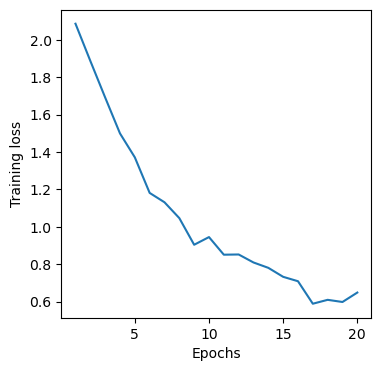

In [21]:
plt.figure(figsize=(4,4))
plt.plot(np.arange(1, EPOCHS+1), losses_sigmoid)
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.show()

In [22]:
pred, test_acc = predict(x_test, y_test, sigmoidParams, sigmoid)
print('Sigmoid Test Accuracy:', test_acc*100,'%')

Sigmoid Test Accuracy: 87.66000000000001 %
